In [78]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import scipy
import cftime
import cartopy
import cartopy.crs as ccrs
import matplotlib.colors as colors
import cmaps
from xhistogram.xarray import histogram
import geopandas as gpd
from matplotlib import cm
import functions_utils

In [79]:
state_borders =\
cartopy.feature.NaturalEarthFeature(category='cultural',\
        name='admin_1_states_provinces_lakes', scale='50m', facecolor='none')

In [80]:
lon_min=190;lon_max=230
lat_min=55;lat_max=72

# READ STATIONS DATA

In [81]:
ifile='/Projects/RAPrototype/GHCND/GHCND_Tmin_Tmax_Tavg_US_30yr.nc'
dso = xr.open_dataset(ifile)
dso = dso.where((dso['latitude']<=lat_max)&(dso['latitude']>=lat_min),drop=True)
dso['TAVG'] = dso['TAVG'].where(dso['TAVG']>-1000)
dso['TAVG'] = dso['TAVG']/10. # degreeC instead of 10th of degreeC
dso = dso.sel(time=slice('1995-01-01','2025-06-30'))


In [82]:
print(dso['TAVG'].min().data,dso['TAVG'].max().data)

-99.9 2303.6


In [83]:
dso

<xarray.Dataset>
Dimensions:          (station: 78, time: 11139)
Coordinates:
  * time             (time) datetime64[ns] 1995-01-01 1995-01-02 ... 2025-06-30
  * station          (station) object 'USW00026533' ... 'USR0000AHOG'
Data variables:
    TMIN             (station, time) float64 -156.0 -156.0 -167.0 ... 83.0 61.0
    TMAX             (station, time) float64 -122.0 -78.0 -83.0 ... 222.0 228.0
    TAVG             (station, time) float64 nan nan nan nan ... 16.7 15.8 15.6
    TMIN_ATTRIBUTES  (station, time) object ',,0' ',,0' ',,0' ... 'H,,U' 'H,,U'
    TMAX_ATTRIBUTES  (station, time) object ',,0' ',,0' ',,0' ... 'H,,U' 'H,,U'
    TAVG_ATTRIBUTES  (station, time) object '' '' '' '' ... ',,U' ',,U' ',,U'
    latitude         (station) float64 66.92 61.07 59.78 ... 64.85 63.89 66.22
    longitude        (station) float64 -151.5 -149.5 -150.8 ... -152.3 -155.7
    elevation        (station) float64 196.5 716.3 701.0 ... 137.2 225.6 208.8
    name             (station) object BETTLES AIRPORT, AK US ... HOGATZA RIVE...

# Get name of stations

In [84]:
Tstation=[]
for ip in range(0,len(dso['station'])):
  Tstation.append(dso['station'][ip].data.item())

/tmp/ipykernel_502608/2628988310.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors=cm.get_cmap('turbo',len(dso['station']))


Text(0.5, 1.0, 'GHNCD stations - Alaska')

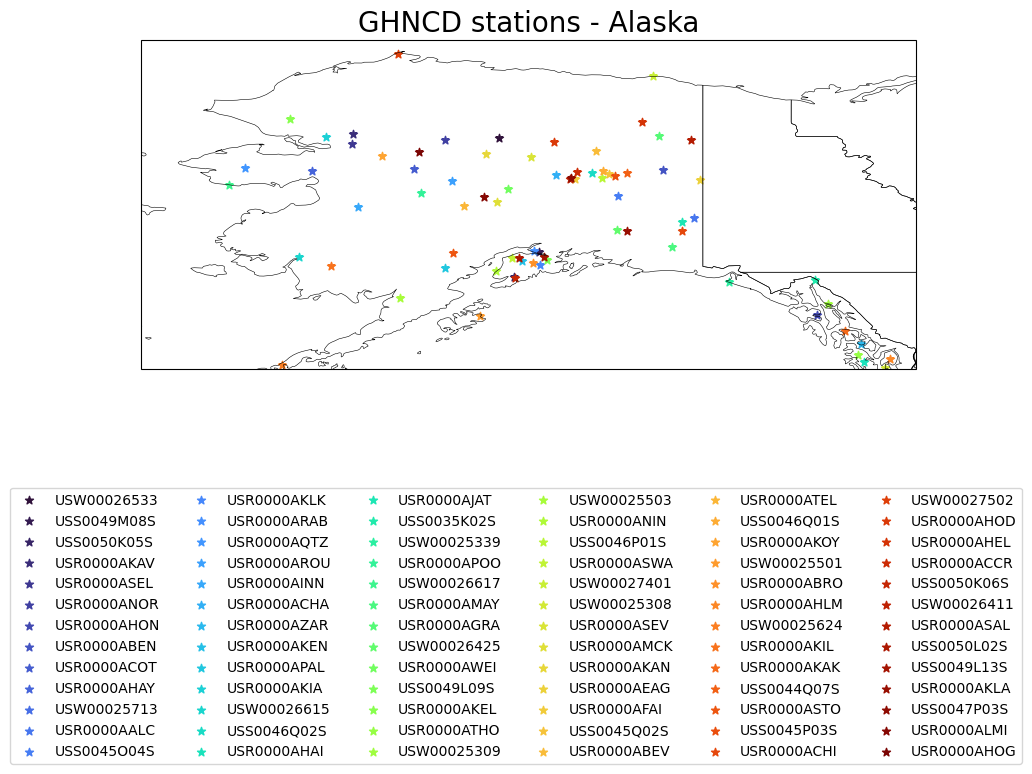

In [85]:
cmap=cmaps.BlGrYeOrReVi200
proj=ccrs.PlateCarree()
colors=cm.get_cmap('turbo',len(dso['station']))
#colors=cm.get_cmap('turbo',10)

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(10,11),subplot_kw={'projection':proj})

for ip in range(0,len(dso['station'])):
  #for ip in range(30,40):  
  ax.scatter(dso['longitude'][ip],dso['latitude'][ip],marker='*',color=colors(ip),label=dso['station'][ip].data.item())

ax.set_extent([190,230,55,72],proj)
ax.add_feature(state_borders,zorder=100,linewidth=0.4,edgecolor='k')
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center',ncol=6,bbox_to_anchor=(0.5,-0.02),prop={'size': 10})
ax.set_title('GHNCD stations - Alaska',fontsize=20)

# Remove stations due to too much value outside of raisonnable range and too many missing data

In [86]:
Tstation=[]
for ip in range(0,len(dso['station'])):
  Tstation.append(dso['station'][ip].data.item())

In [87]:
ist = [ 0,2, 7,8,10,13,16,17,18,19,22,23,24,25,26,28,30,33,37,38,39,43,44,46,50,51,52,55,57,58,60,61,62,65,66,67,70]


# TIMESERIES by 10 stations

/tmp/ipykernel_502608/1055001680.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors=cm.get_cmap('turbo',11)
/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future v

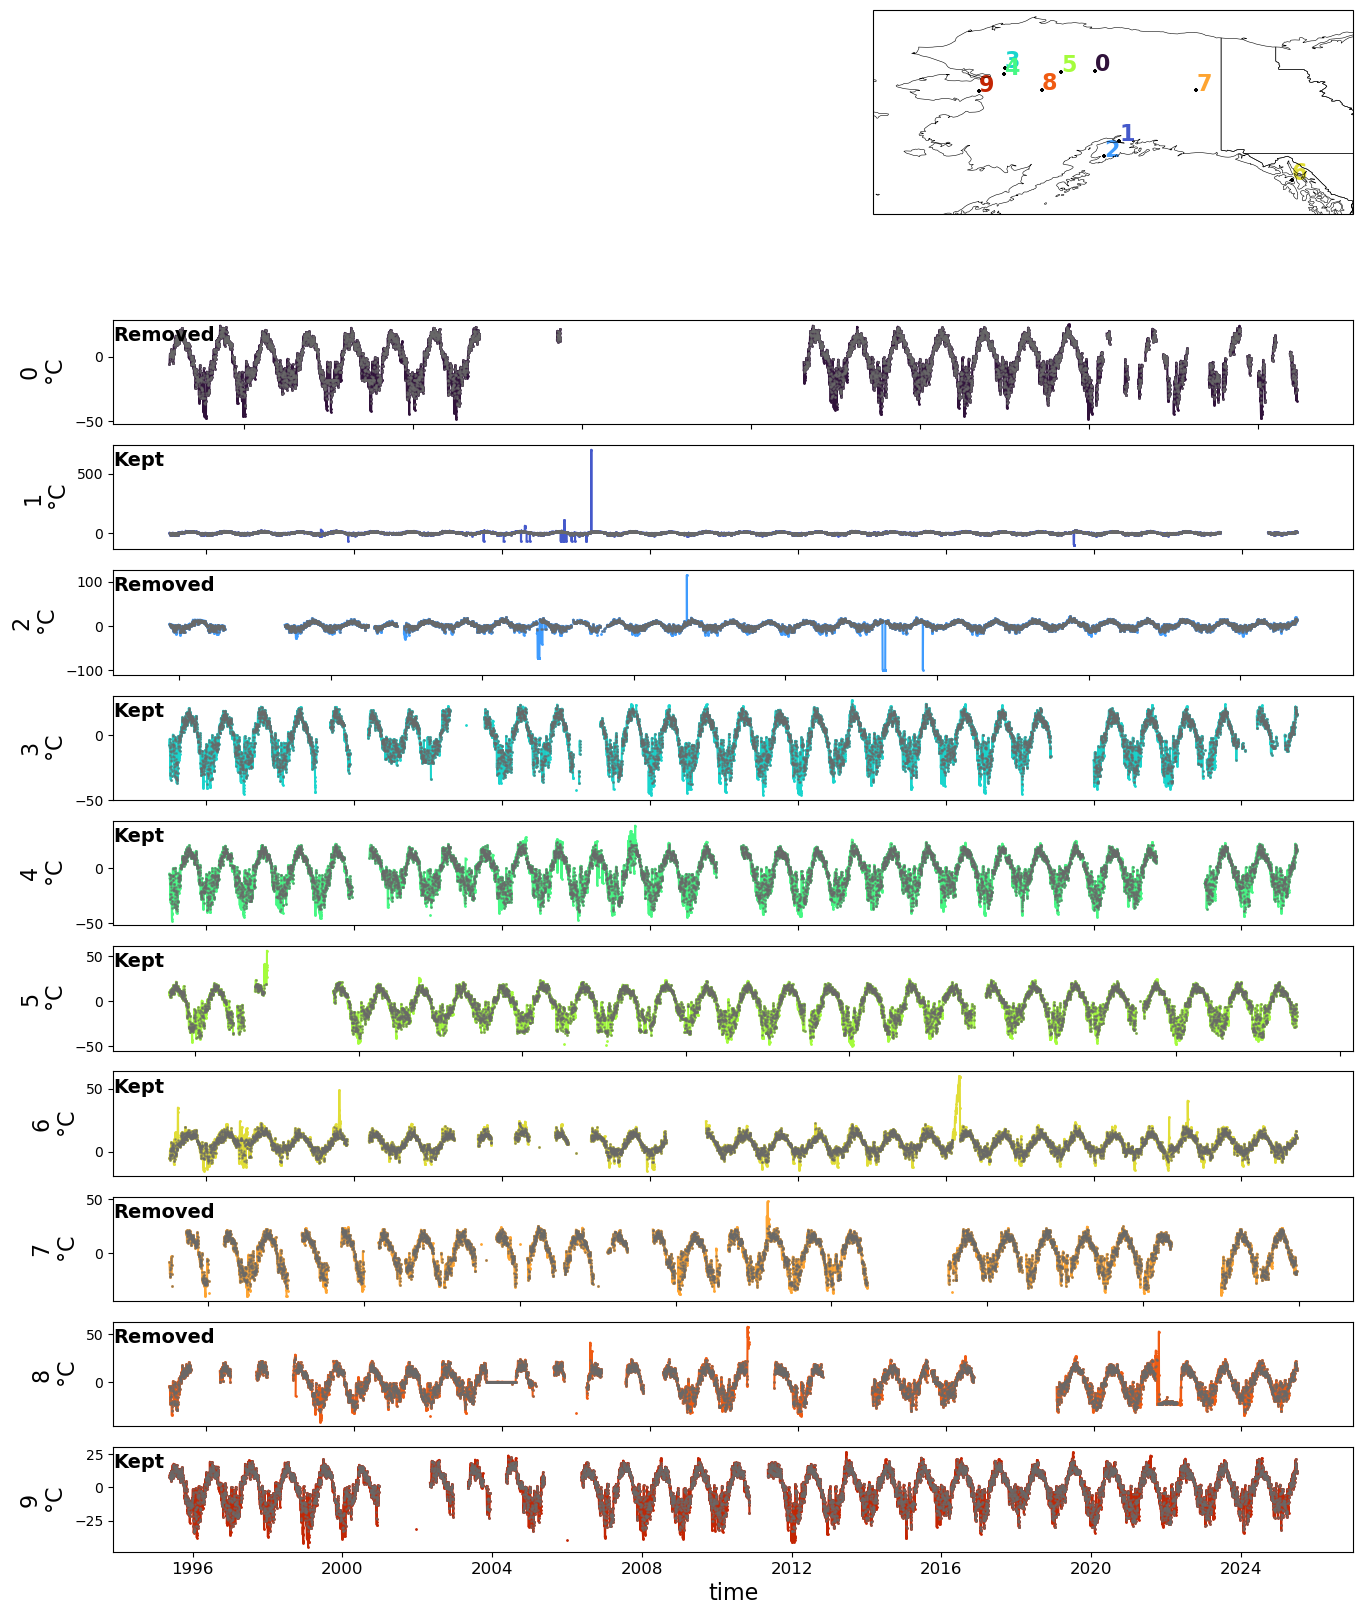

In [88]:
fig, ax = plt.subplots(nrows=10,ncols=1,figsize=(16,16))
colors=cm.get_cmap('turbo',11)
#
ax_inset = fig.add_axes([0.6, 0.86, 0.3, 0.3], projection=ccrs.PlateCarree())

for ip in range(0,10):
  ax_inset.scatter(dso['longitude'][ip],dso['latitude'][ip],marker='+',s=10,color='k')
  ax_inset.text(dso['longitude'][ip],dso['latitude'][ip],ip,color=colors(ip),fontsize=16,fontweight='bold')
  ix=ip
  yyy = dso['TAVG'].isel(station=ip)
  yyyy = functions_utils.remove_outliers_seasons(yyy,2)
  ax[ix].plot(dso['time'],yyy,color=colors(ip),marker='o',markersize=1)
  ax[ix].plot(dso['time'],yyyy,color='dimgrey',marker='o',markersize=1,linewidth=0.05,alpha=0.5)
  ax[ix].set_ylabel(f'{ip}\n$\degree$C',fontsize=16)  
  if ip in list(ist):
    ax[ix].text(0,0.8,'Removed',fontsize=14,fontweight='bold',color='k',transform=ax[ix].transAxes)
  else:
    ax[ix].text(0,0.8,'Kept',fontsize=14,fontweight='bold',color='k',transform=ax[ix].transAxes)
  if ix <9:
    ax[ix].set_xticklabels('')  
  else:  
    ax[ix].set_xticklabels(ax[ix].get_xticklabels(),fontsize=12)  
    ax[ix].set_xlabel('time',fontsize=16)
ax_inset.set_extent([190,230,55,72],proj)
ax_inset.add_feature(state_borders,zorder=100,linewidth=0.4,edgecolor='k')

In color : raw timeseries from GHCND files. In grey, timeseries filtered by keeping data inside -/+ 2σ.

/tmp/ipykernel_502608/1261239399.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors=cm.get_cmap('turbo',11)
/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future v

/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will re

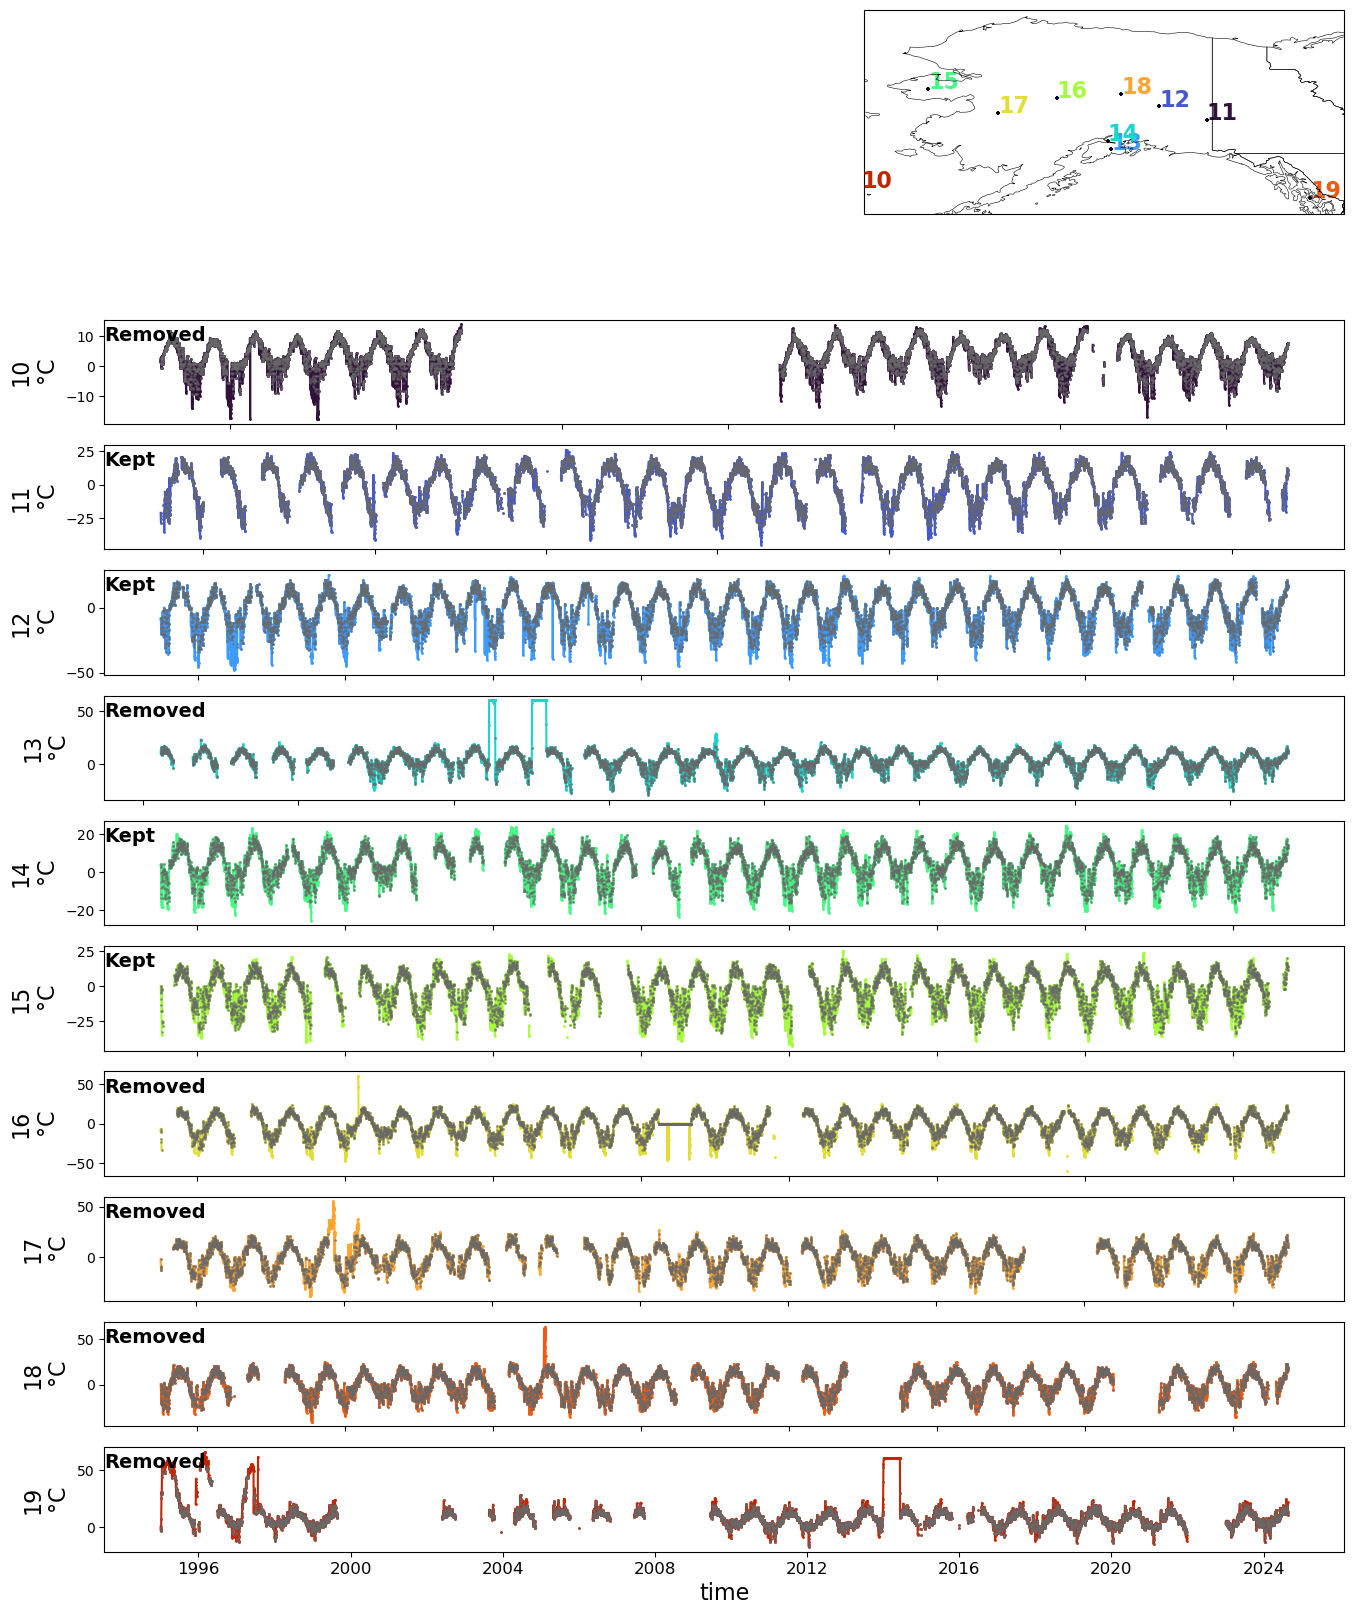

In [89]:
fig, ax = plt.subplots(nrows=10,ncols=1,figsize=(16,16))
colors=cm.get_cmap('turbo',11)
#
ax_inset = fig.add_axes([0.6, 0.86, 0.3, 0.3], projection=ccrs.PlateCarree())

for ip in range(10,20):
  ax_inset.scatter(dso['longitude'][ip],dso['latitude'][ip],marker='+',s=10,color='k')
  ax_inset.text(dso['longitude'][ip],dso['latitude'][ip],ip,color=colors(ix),fontsize=16,fontweight='bold')
  ix=ip-10
  yyy = dso['TAVG'].isel(station=ip)
  yyyy = functions_utils.remove_outliers_seasons(yyy,2)
  ax[ix].plot(dso['time'],yyy,color=colors(ix),marker='o',markersize=1)
  ax[ix].plot(dso['time'],yyyy,color='dimgrey',marker='o',markersize=1,linewidth=0.05,alpha=0.5)
  ax[ix].set_ylabel(f'{ip}\n$\degree$C',fontsize=16)  
  if ip in list(ist):
    ax[ix].text(0,0.8,'Removed',fontsize=14,fontweight='bold',color='k',transform=ax[ix].transAxes)
  else:
    ax[ix].text(0,0.8,'Kept',fontsize=14,fontweight='bold',color='k',transform=ax[ix].transAxes)
  if ix <9:
    ax[ix].set_xticklabels('')  
  else:  
    ax[ix].set_xticklabels(ax[ix].get_xticklabels(),fontsize=12)  
    ax[ix].set_xlabel('time',fontsize=16)
ax_inset.set_extent([190,230,55,72],proj)
ax_inset.add_feature(state_borders,zorder=100,linewidth=0.4,edgecolor='k')

/tmp/ipykernel_502608/920869663.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors=cm.get_cmap('turbo',11)
/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future ve

/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/tmp/ipykernel_502608/920869663.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[ix].set_xticklabels(ax[ix].get_xticklabels(),fontsize=12)


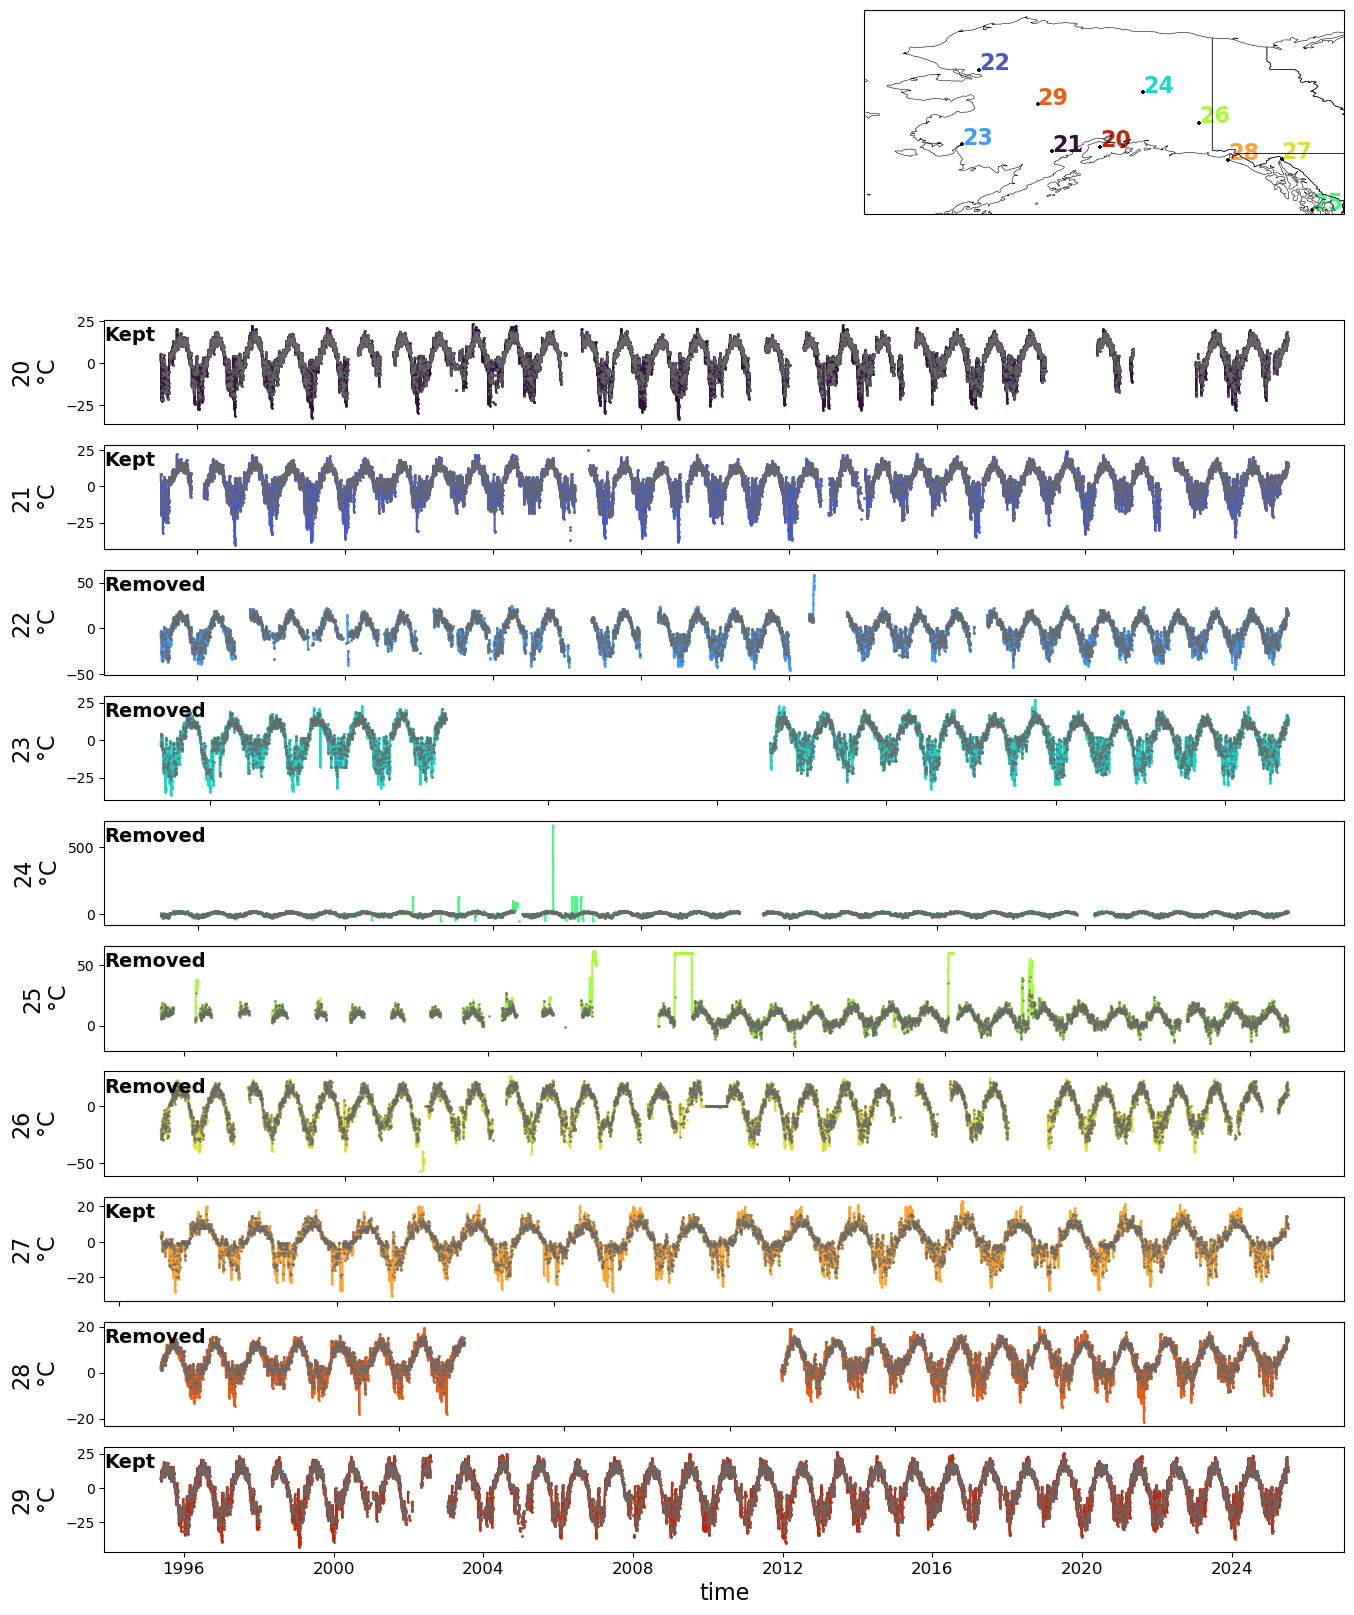

In [90]:
fig, ax = plt.subplots(nrows=10,ncols=1,figsize=(16,16))
colors=cm.get_cmap('turbo',11)
#
ax_inset = fig.add_axes([0.6, 0.86, 0.3, 0.3], projection=ccrs.PlateCarree())

for ip in range(20,30):
  ax_inset.scatter(dso['longitude'][ip],dso['latitude'][ip],marker='+',s=10,color='k')
  ax_inset.text(dso['longitude'][ip],dso['latitude'][ip],ip,color=colors(ix),fontsize=16,fontweight='bold')
  ix=ip-20
  yyy = dso['TAVG'].isel(station=ip)
  yyyy = functions_utils.remove_outliers_seasons(yyy,2)
  ax[ix].plot(dso['time'],yyy,color=colors(ix),marker='o',markersize=1)
  ax[ix].plot(dso['time'],yyyy,color='dimgrey',marker='o',markersize=1,linewidth=0.05,alpha=0.5)
  ax[ix].set_ylabel(f'{ip}\n$\degree$C',fontsize=16)  
  if ip in list(ist):
    ax[ix].text(0,0.8,'Removed',fontsize=14,fontweight='bold',color='k',transform=ax[ix].transAxes)
  else:
    ax[ix].text(0,0.8,'Kept',fontsize=14,fontweight='bold',color='k',transform=ax[ix].transAxes)
  if ix <9:
    ax[ix].set_xticklabels('')  
  else:  
    ax[ix].set_xticklabels(ax[ix].get_xticklabels(),fontsize=12)  
    ax[ix].set_xlabel('time',fontsize=16)
ax_inset.set_extent([190,230,55,72],proj)
ax_inset.add_feature(state_borders,zorder=100,linewidth=0.4,edgecolor='k')

/tmp/ipykernel_502608/2864846655.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors=cm.get_cmap('turbo',11)
/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future v

/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will re

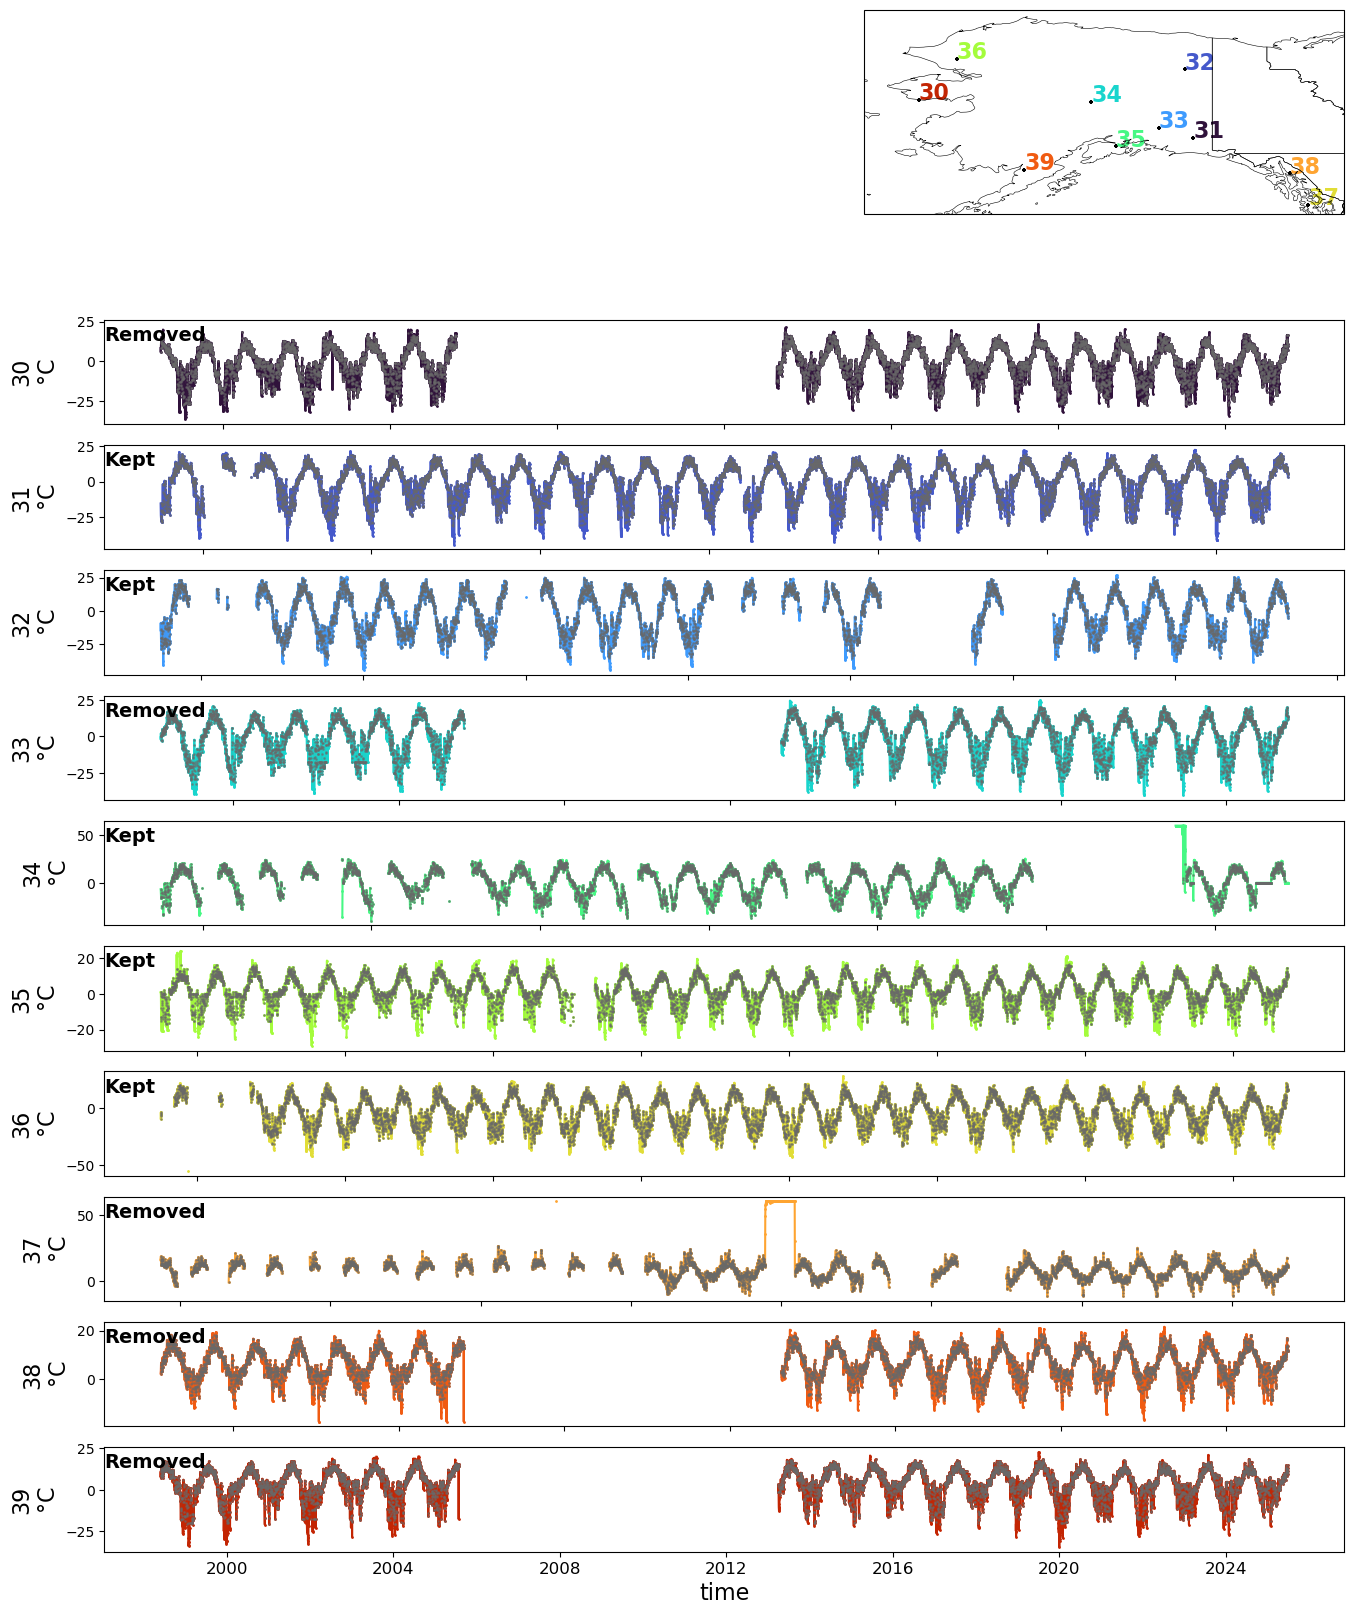

In [91]:
fig, ax = plt.subplots(nrows=10,ncols=1,figsize=(16,16))
colors=cm.get_cmap('turbo',11)
#
ax_inset = fig.add_axes([0.6, 0.86, 0.3, 0.3], projection=ccrs.PlateCarree())

for ip in range(30,40):
  ax_inset.scatter(dso['longitude'][ip],dso['latitude'][ip],marker='+',s=10,color='k')
  ax_inset.text(dso['longitude'][ip],dso['latitude'][ip],ip,color=colors(ix),fontsize=16,fontweight='bold')
  ix=ip-30
  yyy = dso['TAVG'].isel(station=ip)
  yyyy = functions_utils.remove_outliers_seasons(yyy,2)
  ax[ix].plot(dso['time'],yyy,color=colors(ix),marker='o',markersize=1)
  ax[ix].plot(dso['time'],yyyy,color='dimgrey',marker='o',markersize=1,linewidth=0.05,alpha=0.5)
  ax[ix].set_ylabel(f'{ip}\n$\degree$C',fontsize=16)  
  if ip in list(ist):
    ax[ix].text(0,0.8,'Removed',fontsize=14,fontweight='bold',color='k',transform=ax[ix].transAxes)
  else:
    ax[ix].text(0,0.8,'Kept',fontsize=14,fontweight='bold',color='k',transform=ax[ix].transAxes)
  if ix <9:
    ax[ix].set_xticklabels('')  
  else:  
    ax[ix].set_xticklabels(ax[ix].get_xticklabels(),fontsize=12)  
    ax[ix].set_xlabel('time',fontsize=16)
ax_inset.set_extent([190,230,55,72],proj)
ax_inset.add_feature(state_borders,zorder=100,linewidth=0.4,edgecolor='k')

/tmp/ipykernel_502608/1136916413.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors=cm.get_cmap('turbo',11)
/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future v

/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will re

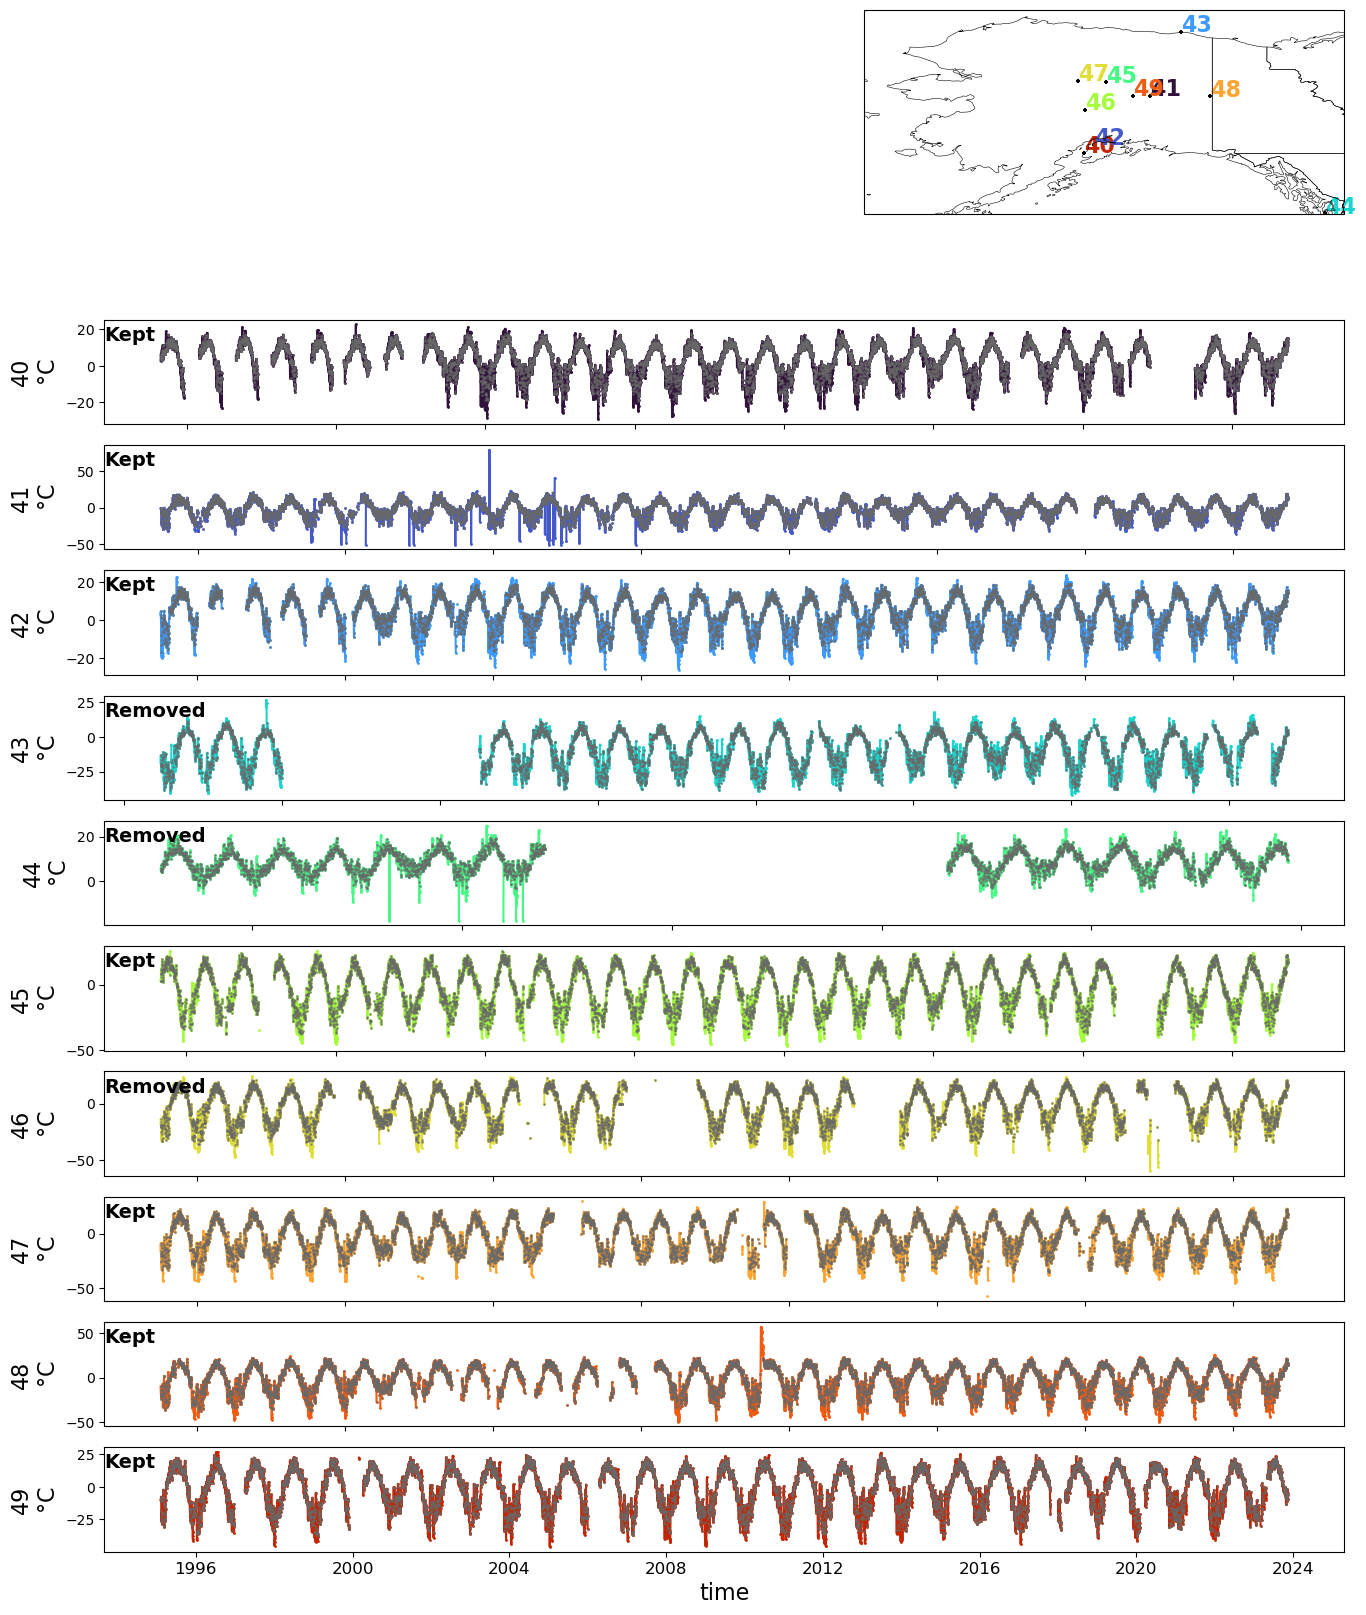

In [92]:
fig, ax = plt.subplots(nrows=10,ncols=1,figsize=(16,16))
colors=cm.get_cmap('turbo',11)
#
ax_inset = fig.add_axes([0.6, 0.86, 0.3, 0.3], projection=ccrs.PlateCarree())

for ip in range(40,50):
  ax_inset.scatter(dso['longitude'][ip],dso['latitude'][ip],marker='+',s=10,color='k')
  ax_inset.text(dso['longitude'][ip],dso['latitude'][ip],ip,color=colors(ix),fontsize=16,fontweight='bold')
  ix=ip-40
  yyy = dso['TAVG'].isel(station=ip)
  yyyy = functions_utils.remove_outliers_seasons(yyy,2)
  ax[ix].plot(dso['time'],yyy,color=colors(ix),marker='o',markersize=1)
  ax[ix].plot(dso['time'],yyyy,color='dimgrey',marker='o',markersize=1,linewidth=0.05,alpha=0.5)
  ax[ix].set_ylabel(f'{ip}\n$\degree$C',fontsize=16)  
  if ip in list(ist):
    ax[ix].text(0,0.8,'Removed',fontsize=14,fontweight='bold',color='k',transform=ax[ix].transAxes)
  else:
    ax[ix].text(0,0.8,'Kept',fontsize=14,fontweight='bold',color='k',transform=ax[ix].transAxes)
  if ix <9:
    ax[ix].set_xticklabels('')  
  else:  
    ax[ix].set_xticklabels(ax[ix].get_xticklabels(),fontsize=12)  
    ax[ix].set_xlabel('time',fontsize=16)
ax_inset.set_extent([190,230,55,72],proj)
ax_inset.add_feature(state_borders,zorder=100,linewidth=0.4,edgecolor='k')

/tmp/ipykernel_502608/2270858996.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors=cm.get_cmap('turbo',11)
/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future v

/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will re

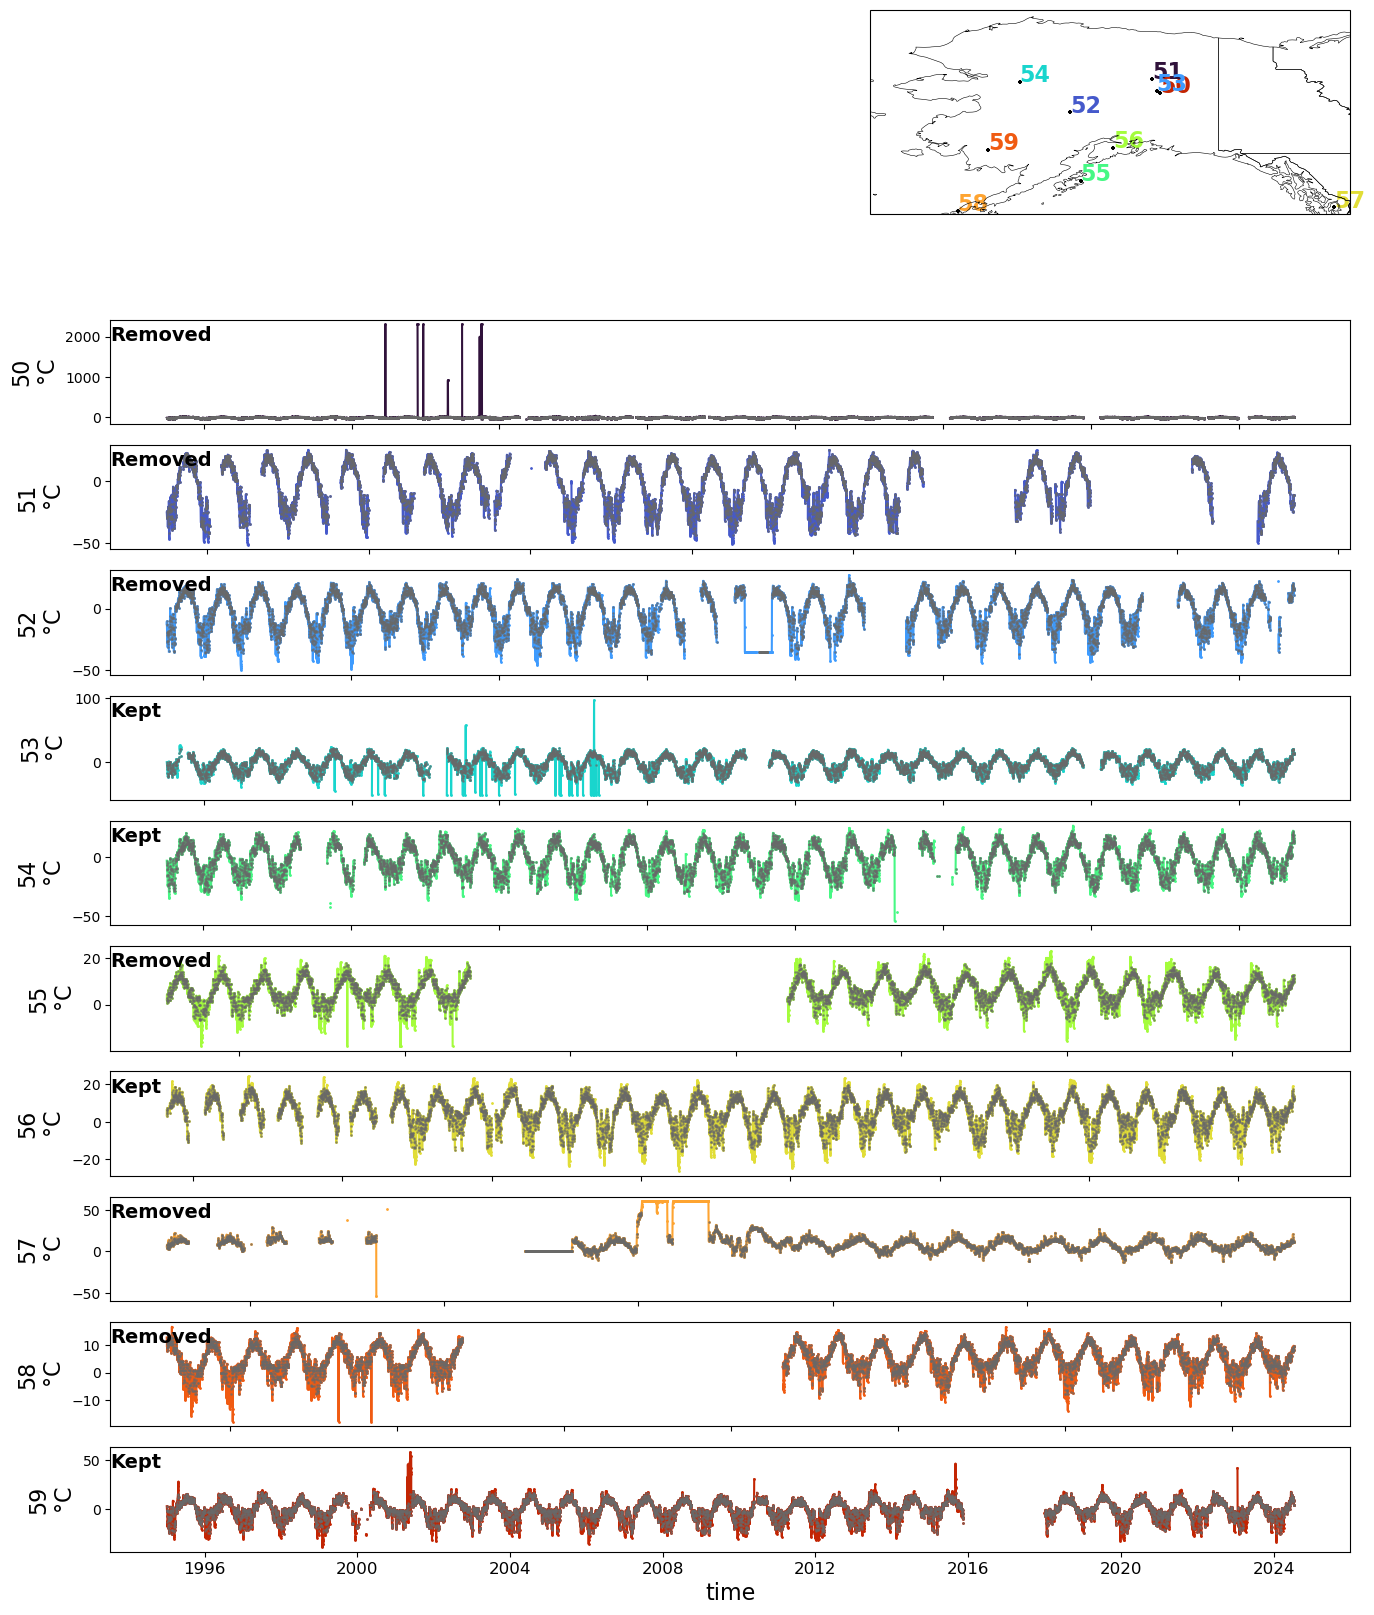

In [93]:
fig, ax = plt.subplots(nrows=10,ncols=1,figsize=(16,16))
colors=cm.get_cmap('turbo',11)
#
ax_inset = fig.add_axes([0.6, 0.86, 0.3, 0.3], projection=ccrs.PlateCarree())

for ip in range(50,60):
  ax_inset.scatter(dso['longitude'][ip],dso['latitude'][ip],marker='+',s=10,color='k')
  ax_inset.text(dso['longitude'][ip],dso['latitude'][ip],ip,color=colors(ix),fontsize=16,fontweight='bold')
  ix=ip-50
  yyy = dso['TAVG'].isel(station=ip)
  yyyy = functions_utils.remove_outliers_seasons(yyy,2)
  ax[ix].plot(dso['time'],yyy,color=colors(ix),marker='o',markersize=1)
  ax[ix].plot(dso['time'],yyyy,color='dimgrey',marker='o',markersize=1,linewidth=0.05,alpha=0.5)
  ax[ix].set_ylabel(f'{ip}\n$\degree$C',fontsize=16)  
  if ip in list(ist):
    ax[ix].text(0,0.8,'Removed',fontsize=14,fontweight='bold',color='k',transform=ax[ix].transAxes)
  else:
    ax[ix].text(0,0.8,'Kept',fontsize=14,fontweight='bold',color='k',transform=ax[ix].transAxes)
  if ix <9:
    ax[ix].set_xticklabels('')  
  else:  
    ax[ix].set_xticklabels(ax[ix].get_xticklabels(),fontsize=12)  
    ax[ix].set_xlabel('time',fontsize=16)
ax_inset.set_extent([190,230,55,72],proj)
ax_inset.add_feature(state_borders,zorder=100,linewidth=0.4,edgecolor='k')

/tmp/ipykernel_502608/3372899854.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors=cm.get_cmap('turbo',11)
/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future v

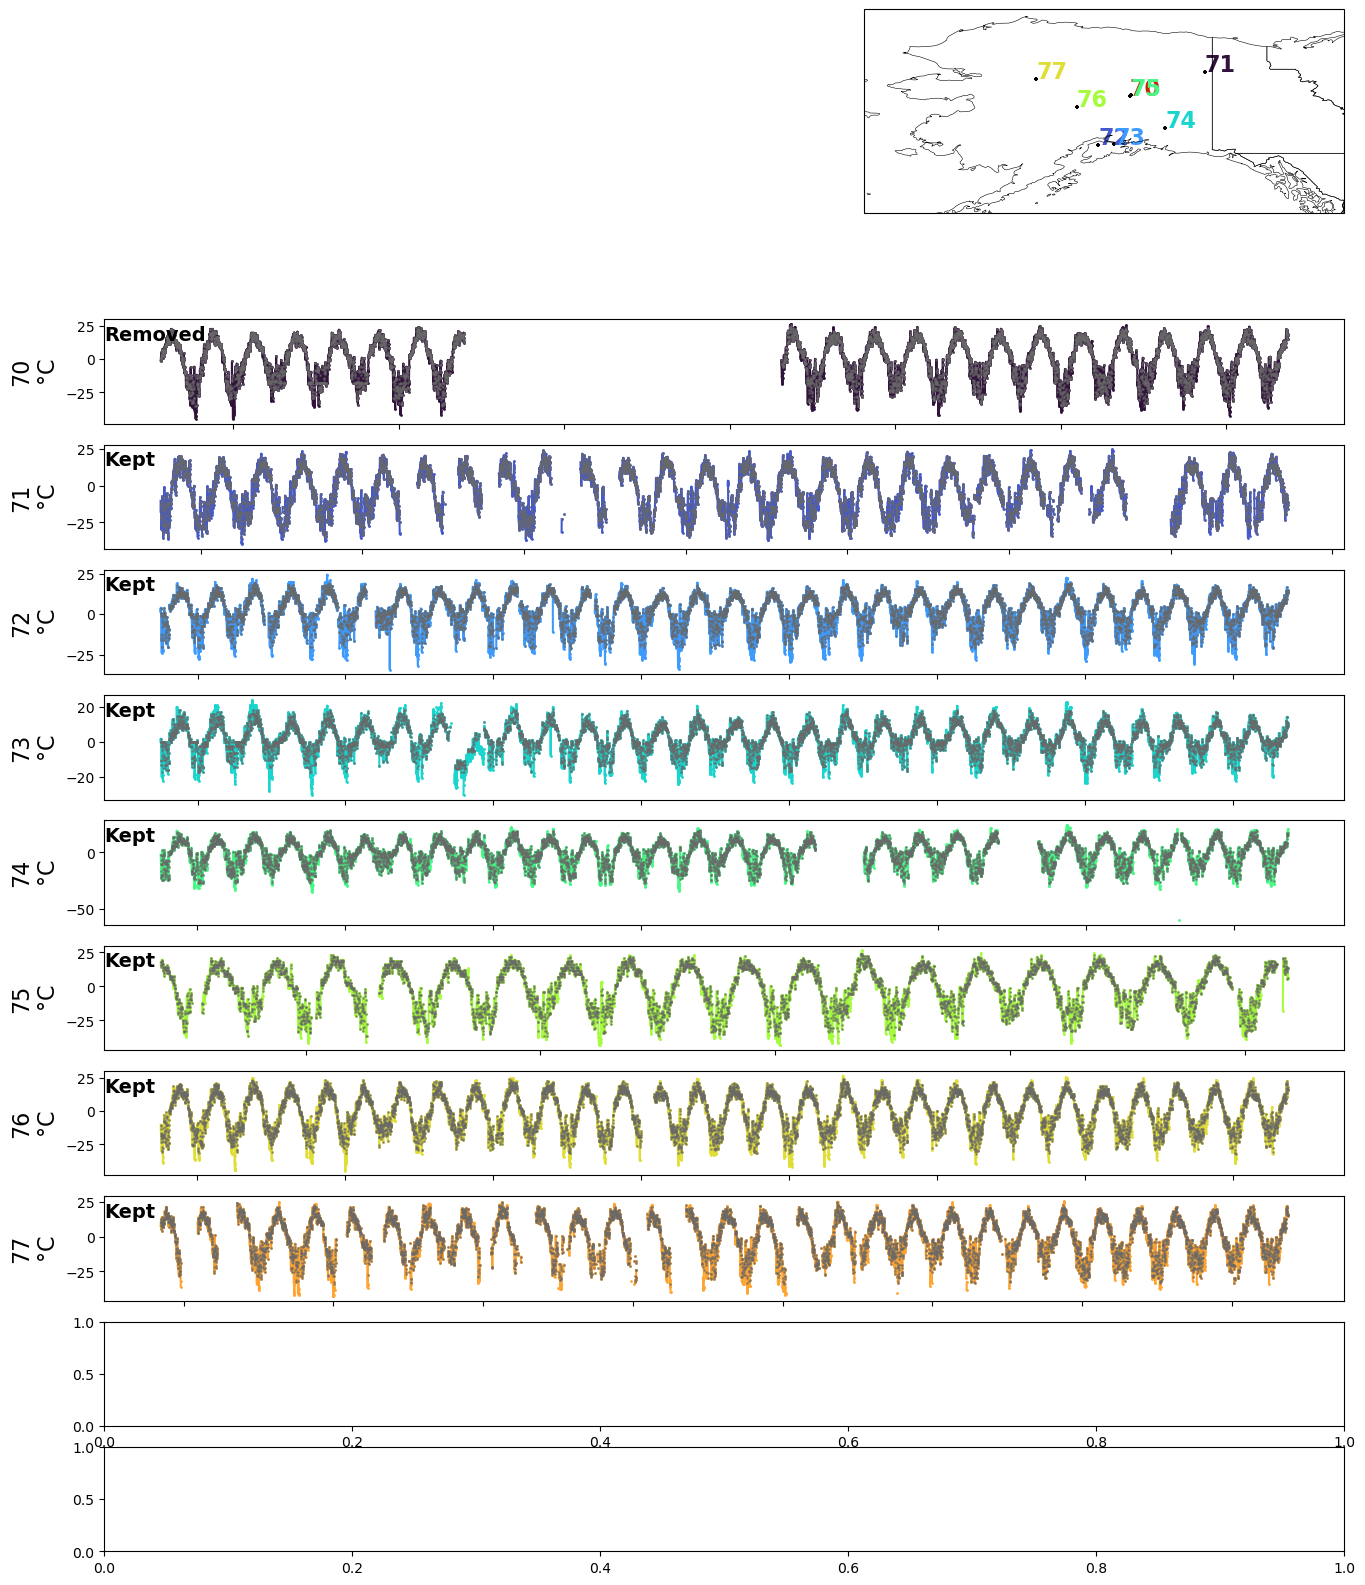

In [94]:
fig, ax = plt.subplots(nrows=10,ncols=1,figsize=(16,16))
colors=cm.get_cmap('turbo',11)
#
ax_inset = fig.add_axes([0.6, 0.86, 0.3, 0.3], projection=ccrs.PlateCarree())

for ip in range(70,78):
  ax_inset.scatter(dso['longitude'][ip],dso['latitude'][ip],marker='+',s=10,color='k')
  ax_inset.text(dso['longitude'][ip],dso['latitude'][ip],ip,color=colors(ix),fontsize=16,fontweight='bold')
  ix=ip-70
  yyy = dso['TAVG'].isel(station=ip)
  yyyy = functions_utils.remove_outliers_seasons(yyy,2)
  ax[ix].plot(dso['time'],yyy,color=colors(ix),marker='o',markersize=1)
  ax[ix].plot(dso['time'],yyyy,color='dimgrey',marker='o',markersize=1,linewidth=0.05,alpha=0.5)
  ax[ix].set_ylabel(f'{ip}\n$\degree$C',fontsize=16)  
  if ip in list(ist):
    ax[ix].text(0,0.8,'Removed',fontsize=14,fontweight='bold',color='k',transform=ax[ix].transAxes)
  else:
    ax[ix].text(0,0.8,'Kept',fontsize=14,fontweight='bold',color='k',transform=ax[ix].transAxes)
  if ix <9:
    ax[ix].set_xticklabels('')  
  else:  
    ax[ix].set_xticklabels(ax[ix].get_xticklabels(),fontsize=12)  
    ax[ix].set_xlabel('time',fontsize=16)
ax_inset.set_extent([190,230,55,72],proj)
ax_inset.add_feature(state_borders,zorder=100,linewidth=0.4,edgecolor='k')

In [95]:
for ii in range(0,len(ist)):
  Tstation.remove(dso['station'][ist[ii]].data.item())

In [96]:
ds = dso.sel(station=np.array(Tstation))

/tmp/ipykernel_502608/3204720594.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors=cm.get_cmap('turbo',len(ds['station']))


Text(0.5, 1.0, 'GHNCD stations - Alaska')

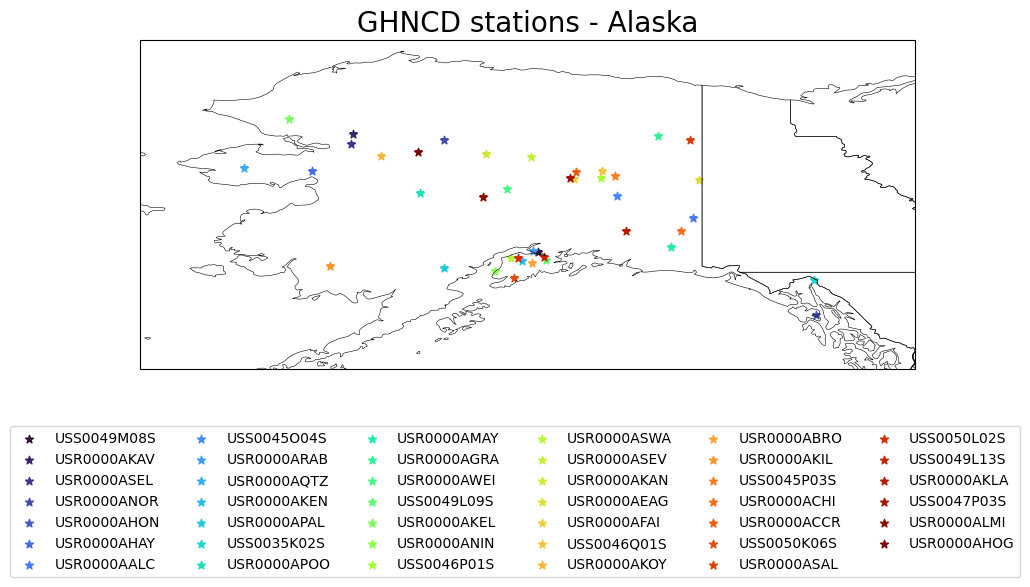

In [97]:
cmap=cmaps.BlGrYeOrReVi200
proj=ccrs.PlateCarree()
colors=cm.get_cmap('turbo',len(ds['station']))
#colors=cm.get_cmap('turbo',10)

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(10,11),subplot_kw={'projection':proj})

for ip in range(0,len(ds['station'])):
  #for ip in range(30,40):  
  ax.scatter(ds['longitude'][ip],ds['latitude'][ip],marker='*',color=colors(ip),label=ds['station'][ip].data.item())

ax.set_extent([190,230,55,72],proj)
ax.add_feature(state_borders,zorder=100,linewidth=0.4,edgecolor='k')
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center',ncol=6,bbox_to_anchor=(0.5,0.15),prop={'size': 10})
ax.set_title('GHNCD stations - Alaska',fontsize=20)

/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will re

Text(0.5, 0, 'time')

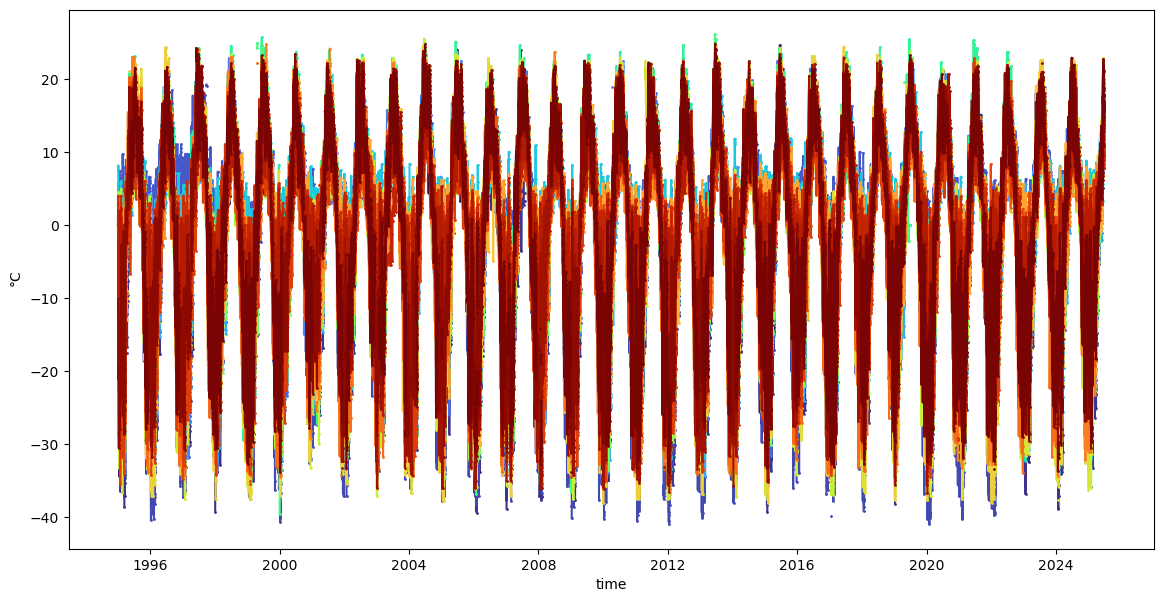

In [98]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(14,7))

for ip in range(0,len(ds['station'])):
  yyy = ds['TAVG'].isel(station=ip)
  yyyy=functions_utils.remove_outliers_seasons(yyy,2)
  ax.plot(ds['time'],yyyy,color=colors(ip),marker='o',markersize=1)
plt.ylabel(f'$\degree$C')  
plt.xlabel('time')

# ERA5 Interpolation to stations

In [99]:
import xesmf
import cmocean
from matplotlib.colors import BoundaryNorm

## Read ERA5

In [100]:
yearb=1995
yeare=1996
temp_var='air'

datadir='/Projects/era5/Dailies/monolevel/'

files=[f'{datadir}/air.2m.{iyear}.nc' for iyear in range(yearb,yeare+1)]
def preprocess(ds):
    return ds.sel(lon=slice(lon_min,lon_max),lat=slice(lat_max,lat_min)).drop_dims('nbnds')
dsera5=xr.open_mfdataset(files,combine='nested', preprocess=preprocess)
dsera5=dsera5.load()
dsera5 = dsera5.sortby('lat')
dsera5['air'] = dsera5['air'] - 273.15
DDD = dsera5.isel(time=0,drop=True)


In [101]:
lon=xr.DataArray(ds['longitude'].data,dims=['lon'])
lat=xr.DataArray(ds['latitude'].data,dims=['lat'])
ds_out = xr.Dataset(coords=dict(lat=lat,lon=lon))
Xg,Yg=np.meshgrid(DDD.lon,DDD.lat)
regridder_NN = xesmf.Regridder(DDD, ds_out, "nearest_s2d")
DEptsi = regridder_NN(dsera5['air'])
T2m = xr.DataArray(np.diagonal(DEptsi, axis1=1, axis2=2),dims=['time','station'])
weights_G = regridder_NN.weights
pts_i=xr.zeros_like(DDD['air']).expand_dims({'station':len(ds['station'])}).copy()
for outj in range(0,len(ds['station'])):
   idlat,idlon=np.where(weights_G[outj*(1+len(ds['station'])),:].data.todense().\
                  reshape((len(dsera5['air'].lat),len(dsera5['air'].lon)))>0)
   pts_i[outj,idlat[:],idlon[:]]=1

/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


/tmp/ipykernel_502608/94673526.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors=cm.get_cmap('turbo',len(ds['station']))
/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1696: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  result = super().scatter(*args, **kwargs)
/home/ghervieux/.conda/envs/Newgaelle/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1696: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have prec

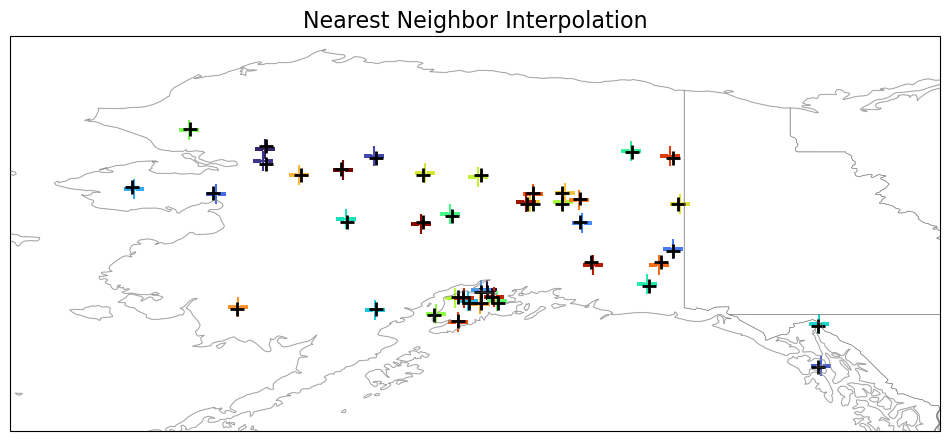

In [102]:
# Choose a colormap
cmap = cmocean.cm.thermal
colors=cm.get_cmap('turbo',len(ds['station']))

#####
levels = np.arange(-50,26,1)
# Create a BoundaryNorm instance
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
###########
fig, axs = plt.subplots(nrows=1,ncols=1,subplot_kw={'projection': ccrs.PlateCarree()},
                      figsize=(12,8))
fig.subplots_adjust(bottom=0.1, top=0.95,hspace=0.02)
## GLORYS
for outj in range(0,len(ds['station'])):
  data=xr.where(pts_i[outj,:,:]==1,100,np.nan)
  axs.scatter(Xg,Yg,s=data, marker='+',c='None',ec='k',zorder=10,lw=2 , transform=ccrs.PlateCarree())
for ic in range(len(ds['station'])):
  axs.scatter(lon[ic],lat[ic], marker='+',transform=ccrs.PlateCarree(),s=200,c=colors(ic),)
axs.set_title(f'Nearest Neighbor Interpolation',fontsize=16)

axs.grid()
axs.set_ylabel(f'')
axs.set_xlabel(f'')
axs.coastlines(color='silver',alpha=0.5)
axs.grid(color='gray', alpha=0.5, linestyle='--')
axs.set_extent([lon_min,lon_max,lat_min,lat_max],proj)
axs.add_feature(state_borders,zorder=100,linewidth=0.4,edgecolor='dimgrey',alpha=0.75)


In color: the location of the  GHNCD's station. In black the nearest grid point of ERA5's grid. 